In [1]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [2]:
import os
import math
import random
import cv2
import numpy as np
import tensorflow as tf
import re
import sys
import time

#if you have multiple GPU on the machine, choose only one to use on this notebook
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#let the gpu allocates memory space dynamically
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction=0.8

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class DatasetRunner:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline ready to be fed into a model.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self, common_params, dataset_params):
        
        self.width = common_params['image_size']
        self.height = common_params['image_size']
        self.batch_size = common_params['batch_size']
        self.num_classes = common_params['num_classes']
        self.data_path = dataset_params['path']
        self.thread_num = dataset_params['thread_num']
        self.image_dir = dataset_params['image_dir']
        
        self.max_objects = common_params['max_objects_per_image']
            
        self.graph = tf.Graph()
        self.sess = tf.Session(graph=self.graph, config=config)
        
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(self.data_path, 'r')
        
        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, self.max_objects))
            if len(self.record_list[-1])<self.max_objects*5:
                self.record_list[-1] = self.record_list[-1] +\
                [float(0), float(0), float(0), float(0), float(0)]*\
                (self.max_objects-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1])>self.max_objects*5:
                self.record_list[-1] = self.record_list[-1][:self.max_objects*5]

        self.build_train_data_tensor()
            
    def build_train_data_tensor(self):
        
        def data_generator(image_name, raw_labels, object_num):
            image_file = tf.read_file(self.image_dir+image_name)
            image = tf.image.decode_jpeg(image_file, channels=3)

            h = tf.shape(image)[0]
            w = tf.shape(image)[1]

            width_rate = self.width * 1.0 / tf.cast(w, tf.float32) 
            height_rate = self.height * 1.0 / tf.cast(h, tf.float32) 

            image = tf.image.resize_images(image, size=[self.height,self.width])
            
            raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)
            
            xmin = raw_labels[:, 0]
            ymin = raw_labels[:, 1]
            xmax = raw_labels[:, 2]
            ymax = raw_labels[:, 3]
            class_num = raw_labels[:, 4]
            
            xcenter = (xmin + xmax) * 1.0 / 2.0 * width_rate
            ycenter = (ymin + ymax) * 1.0 / 2.0 * height_rate
            
            box_w = (xmax - xmin) * width_rate
            box_h = (ymax - ymin) * height_rate
            
            labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis = 1)

            return image, labels, tf.cast(object_num, tf.int32)
            

        with self.graph.as_default():
            
            dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                          np.array(self.record_list), 
                                                          np.array(self.object_num_list)))

            dataset = dataset.map(data_generator, num_parallel_calls = self.thread_num)
            dataset = dataset.batch(self.batch_size)
            dataset = dataset.shuffle(self.batch_size) 
            dataset = dataset.repeat()

            self.iterator = tf.data.Iterator.from_structure(dataset.output_types)  
            self.data_init_op = self.iterator.make_initializer(dataset)

            self.sess.run(self.data_init_op)
            self.iterate_op = self.iterator.get_next()
            
    def batch(self):
        images, labels, objects_num = self.sess.run(self.iterate_op)

        while objects_num.shape[0] < self.batch_size:
            images, labels, objects_num = self.sess.run(self.iterate_op)
        
        images = images/255 * 2 - 1
        
        return images, labels, objects_num
        
        
    def __del__(self):
        self.close()

    def close(self):

        self.sess.close()
        

In [8]:
class YoloTinyNet(object):

    def __init__(self, common_params, net_params, test=False):
        """
        common params: a params dict
        net_params   : a params dict
        """
        #pretrained variable collection
        self.pretrained_collection = []
        #trainable variable collection
        self.trainable_collection = []
         
        #process params
        self.image_size = int(common_params['image_size'])
        self.num_classes = int(common_params['num_classes'])
        self.cell_size = int(net_params['cell_size'])
        self.boxes_per_cell = int(net_params['boxes_per_cell'])
        self.batch_size = int(common_params['batch_size'])
        self.weight_decay = float(net_params['weight_decay'])

        if not test:
            self.object_scale = float(net_params['object_scale'])
            self.noobject_scale = float(net_params['noobject_scale'])
            self.class_scale = float(net_params['class_scale'])
            self.coord_scale = float(net_params['coord_scale'])
         
    def _variable_on_cpu(self, name, shape, initializer, pretrain=True, train=True):
        """Helper to create a Variable stored on CPU memory.
        Args:
          name: name of the Variable
          shape: list of ints
          initializer: initializer of Variable
        Returns:
          Variable Tensor
        """
        with tf.device('/cpu:0'):
            var = tf.get_variable(name, shape, initializer=initializer, dtype=tf.float32)
            if pretrain:
                self.pretrained_collection.append(var)
            if train:
                self.trainable_collection.append(var)
        return var 
    
    def _variable_with_weight_decay(self, name, shape, stddev, wd, pretrain=True, train=True):
        """Helper to create an initialized Variable with weight decay.
        Note that the Variable is initialized with truncated normal distribution
        A weight decay is added only if one is specified.
        Args:
          name: name of the variable 
          shape: list of ints
          stddev: standard devision of a truncated Gaussian
          wd: add L2Loss weight decay multiplied by this float. If None, weight 
          decay is not added for this Variable.
       Returns:
          Variable Tensor 
        """
        var = self._variable_on_cpu(name, shape,
            tf.truncated_normal_initializer(stddev=stddev, dtype=tf.float32), pretrain, train)
        if wd is not None:
            weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
            tf.add_to_collection('losses', weight_decay)
        return var 
    
    def conv_block(self, input, scope, kernel_width, kernel_height, inp_channel, out_channel, 
                    strides = [1, 1, 1, 1], padding='SAME', pretrain=False, train=True):
        with tf.variable_scope(scope) as scope:
            kernel = self._variable_with_weight_decay('weights', [kernel_width, kernel_width, inp_channel, out_channel], 
                                        stddev=0.04, wd=self.weight_decay, pretrain=pretrain, train=train)
            bias = self._variable_on_cpu('bias', [out_channel], tf.constant_initializer(0.0))

            conv = tf.nn.conv2d(input, kernel, strides=strides, padding=padding)
            return self.leaky_relu(conv+bias)

    def max_pool_2x2(self, input):
        return tf.nn.max_pool(input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    def fully(self, scope, input, in_dimension, out_dimension, leaky=True, pretrain=True, train=True):
        with tf.variable_scope(scope) as scope:
            reshape = tf.reshape(input, [tf.shape(input)[0], -1])

            weights = self._variable_with_weight_decay('weights', shape=[in_dimension, out_dimension],
                                  stddev=0.04, wd=self.weight_decay, pretrain=pretrain, train=train)
            biases = self._variable_on_cpu('biases', [out_dimension], tf.constant_initializer(0.0), pretrain, train)
            local = tf.matmul(reshape, weights) + biases

            if leaky:
                local = self.leaky_relu(local)
            else:
                local = tf.identity(local, name=scope.name)

        return local
    
    def leaky_relu(self, x, alpha=0.1, dtype=tf.float32):
        x = tf.cast(x, dtype=dtype)
        
        return tf.nn.leaky_relu(x, alpha=alpha)
    
    
    def inference(self, images):
        """Build the yolo model
        Input the images, output prediction boxes(center_x, center_y, w, h, scale) and the corresponding classes
        
        Args:
          images:  4-D tensor [batch_size, image_height, image_width, channels]
        Returns:
          predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        """
        #images = tf.reshape(images, [-1, self.image_size*self.image_size*3])
        
        conv2 = self.conv_block(images, "conv2", 7, 7, 3, 64, strides=[1,2,2,1])
        h_pool3 = self.max_pool_2x2(conv2)
        
        conv4 = self.conv_block(h_pool3, "conv4", 3, 3, 64, 192)
        h_pool5 = self.max_pool_2x2(conv4)
        
        conv6 = self.conv_block(h_pool5, "conv6", 1, 1, 192, 128)
        conv7 = self.conv_block(conv6, "conv7", 3, 3, 128, 256)
        conv8 = self.conv_block(conv7, "conv8", 1, 1, 256, 256)
        conv9 = self.conv_block(conv8, "conv9", 3, 3, 256, 512)
        h_pool10 = self.max_pool_2x2(conv9)
        
        conv11 = self.conv_block(h_pool10, "conv11", 1, 1, 512, 256)
        conv12 = self.conv_block(conv11, "conv12", 3, 3, 256, 512)
        conv13 = self.conv_block(conv12, "conv13", 1, 1, 512, 256)
        conv14 = self.conv_block(conv13, "conv14", 3, 3, 256, 512)
        conv15 = self.conv_block(conv14, "conv15", 1, 1, 512, 256)
        conv16 = self.conv_block(conv15, "conv16", 3, 3, 256, 512)
        conv17 = self.conv_block(conv16, "conv17", 1, 1, 512, 256)
        conv18 = self.conv_block(conv17, "conv18", 3, 3, 256, 512)
        conv19 = self.conv_block(conv18, "conv19", 1, 1, 512, 512)
        conv20 = self.conv_block(conv19, "conv20", 3, 3, 512, 1024)
        h_pool21 = self.max_pool_2x2(conv20)
        
        conv22 = self.conv_block(h_pool21, "conv22", 1, 1, 1024, 512)
        conv23 = self.conv_block(conv22, "conv23", 3, 3, 512, 1024)
        conv24 = self.conv_block(conv23, "conv24", 1, 1, 1024, 512)
        conv25 = self.conv_block(conv24, "conv25", 3, 3, 512, 1024)
        conv26 = self.conv_block(conv25, "conv26", 3, 3, 1024, 1024)
        conv28 = self.conv_block(conv26, "conv28", 3, 3, 1024, 1024, strides=[1,2,2,1])
        conv29 = self.conv_block(conv28, "conv29", 3, 3, 1024, 1024)
        conv30 = self.conv_block(conv29, "conv30", 3, 3, 1024, 1024)
        trans31 = tf.transpose(conv30, [0,3,1,2], name="trans31")
        flat32 = tf.layers.Flatten()(trans31)
                
        #fully0 = self.fully('local0', images, self.image_size*self.image_size*3, 256)
        fully0 = self.fully('local0', flat32, 7*7*1024, 256)
        fully1 = self.fully('local1', fully0, 256, 512)
        fully2 = self.fully('local2', fully1, 512, 4096)
        fully3 = self.fully('local3', fully2, 4096, self.cell_size * self.cell_size * 
                            (self.num_classes + self.boxes_per_cell * 5), leaky=False,
                            pretrain=False, train=True)

        n1 = self.cell_size * self.cell_size * self.num_classes

        n2 = n1 + self.cell_size * self.cell_size * self.boxes_per_cell

        class_probs = tf.reshape(fully3[:, 0:n1], (-1, self.cell_size, self.cell_size, self.num_classes))
        scales = tf.reshape(fully3[:, n1:n2], (-1, self.cell_size, self.cell_size, self.boxes_per_cell))
        boxes = tf.reshape(fully3[:, n2:], (-1, self.cell_size, self.cell_size, self.boxes_per_cell * 4))

        predicts = tf.concat([class_probs, scales, boxes], 3)

        return predicts

    def iou(self, boxes1, boxes2):
        """calculate ious
        Args:
          boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
          boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)
          
        Return:
          iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
        """
        
        #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
        boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                          boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])
        
        #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
        boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

        boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                          boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

        #calculate the left up point of boxes' overlap area
        lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
        #calculate the right down point of boxes overlap area
        rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

        #intersection
        intersection = rd - lu 

        #the size of the intersection area
        inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]
        
        mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

        #if intersection is negative, then the boxes don't overlap
        inter_square = mask * inter_square

        #calculate the boxs1 square and boxs2 square
        square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
        square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

        return inter_square/(square1 + square2 - inter_square + 1e-6)


    def losses_calculation(self, num, object_num, loss, predict, labels, nilboy):
        """
        calculate loss
        Args:
          predict: 3-D tensor [cell_size, cell_size, 5 * boxes_per_cell]
          labels : [max_objects, 5]  (x_center, y_center, w, h, class)
        """
        label = labels[num:num+1, :]
        label = tf.reshape(label, [-1])

        #calculate objects  tensor [CELL_SIZE, CELL_SIZE]
        min_x = (label[0] - label[2] / 2) / (self.image_size / self.cell_size)
        max_x = (label[0] + label[2] / 2) / (self.image_size / self.cell_size)

        min_y = (label[1] - label[3] / 2) / (self.image_size / self.cell_size)
        max_y = (label[1] + label[3] / 2) / (self.image_size / self.cell_size)

        min_x = tf.floor(min_x)
        min_y = tf.floor(min_y)

        max_x = tf.minimum(tf.ceil(max_x), self.cell_size)
        max_y = tf.minimum(tf.ceil(max_y), self.cell_size)

        temp = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
        objects = tf.ones(temp, tf.float32)

        temp = tf.cast(tf.stack([min_y, self.cell_size - max_y, min_x, self.cell_size - max_x]), tf.int32)
        temp = tf.reshape(temp, (2, 2))
        objects = tf.pad(objects, temp, "CONSTANT")

        #calculate objects  tensor [CELL_SIZE, CELL_SIZE]
        #calculate responsible tensor [CELL_SIZE, CELL_SIZE]
        center_x = label[0] / (self.image_size / self.cell_size)
        center_x = tf.floor(center_x)

        center_y = label[1] / (self.image_size / self.cell_size)
        center_y = tf.floor(center_y)

        response = tf.ones([1, 1], tf.float32)

        temp = tf.cast(tf.stack([center_y, self.cell_size - center_y - 1, 
                                 center_x, self.cell_size -center_x - 1]), 
                       tf.int32)
        self.tmp = tf.stack([center_y, self.cell_size - center_y - 1, 
                             center_x, self.cell_size -center_x - 1])
        temp = tf.reshape(temp, (2, 2))
        response = tf.pad(response, temp, "CONSTANT")
        #objects = response

        #calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
        predict_boxes = predict[:, :, self.num_classes + self.boxes_per_cell:]

        predict_boxes = tf.reshape(predict_boxes, [self.cell_size, 
                                                   self.cell_size, 
                                                   self.boxes_per_cell, 4])

        predict_boxes = predict_boxes * [self.image_size / self.cell_size, 
                                         self.image_size / self.cell_size, 
                                         self.image_size, self.image_size]

        base_boxes = np.zeros([self.cell_size, self.cell_size, 4])

        #for each cell
        for y in range(self.cell_size):
            for x in range(self.cell_size):
                
                base_boxes[y, x, :] = [self.image_size / self.cell_size * x, self.image_size / self.cell_size * y, 0, 0]
                
        base_boxes = np.tile(np.resize(base_boxes, [self.cell_size, self.cell_size, 1, 4]), [1, 1, self.boxes_per_cell, 1])

        #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
        predict_boxes = base_boxes + predict_boxes

        iou_predict_truth = self.iou(predict_boxes, label[0:4])
        #calculate C [cell_size, cell_size, boxes_per_cell]
        C = iou_predict_truth * tf.reshape(response, [self.cell_size, self.cell_size, 1])

        #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
        I = iou_predict_truth * tf.reshape(response, (self.cell_size, self.cell_size, 1))

        max_I = tf.reduce_max(I, 2, keep_dims=True)

        I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (self.cell_size, self.cell_size, 1))

        #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
        no_I = tf.ones_like(I, dtype=tf.float32) - I 


        p_C = predict[:, :, self.num_classes:self.num_classes + self.boxes_per_cell]

        #calculate truth x, y, sqrt_w, sqrt_h 0-D
        x = label[0]
        y = label[1]

        sqrt_w = tf.sqrt(tf.abs(label[2]))
        sqrt_h = tf.sqrt(tf.abs(label[3]))

        #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
        p_x = predict_boxes[:, :, :, 0]
        p_y = predict_boxes[:, :, :, 1]

        #p_sqrt_w = tf.sqrt(tf.abs(predict_boxes[:, :, :, 2])) * ((tf.cast(predict_boxes[:, :, :, 2] > 0, tf.float32) * 2) - 1)
        #p_sqrt_h = tf.sqrt(tf.abs(predict_boxes[:, :, :, 3])) * ((tf.cast(predict_boxes[:, :, :, 3] > 0, tf.float32) * 2) - 1)
        #p_sqrt_w = tf.sqrt(tf.maximum(0.0, predict_boxes[:, :, :, 2]))
        #p_sqrt_h = tf.sqrt(tf.maximum(0.0, predict_boxes[:, :, :, 3]))
        #p_sqrt_w = predict_boxes[:, :, :, 2]
        #p_sqrt_h = predict_boxes[:, :, :, 3]
        p_sqrt_w = tf.sqrt(tf.minimum(self.image_size * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
        p_sqrt_h = tf.sqrt(tf.minimum(self.image_size * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))
        
        #calculate truth p 1-D tensor [NUM_CLASSES]
        P = tf.one_hot(tf.cast(label[4], tf.int32), self.num_classes, dtype=tf.float32)

        #calculate predict p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
        p_P = predict[:, :, 0:self.num_classes]

        #class_loss
        class_loss = tf.nn.l2_loss(tf.reshape(objects, (self.cell_size, self.cell_size, 1)) * (p_P - P)) * self.class_scale
        #class_loss = tf.nn.l2_loss(tf.reshape(response, (self.cell_size, self.cell_size, 1)) * (p_P - P)) * self.class_scale

        #object_loss
        object_loss = tf.nn.l2_loss(I * (p_C - C)) * self.object_scale
        #object_loss = tf.nn.l2_loss(I * (p_C - (C + 1.0)/2.0)) * self.object_scale

        #noobject_loss
        #noobject_loss = tf.nn.l2_loss(no_I * (p_C - C)) * self.noobject_scale
        noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * self.noobject_scale

        #coord_loss
        coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(self.image_size/self.cell_size)) +
                     tf.nn.l2_loss(I * (p_y - y)/(self.image_size/self.cell_size)) +
                     tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/ self.image_size +
                     tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/self.image_size) * self.coord_scale

        nilboy = I

        return (num + 1, object_num, [loss[0] + class_loss, 
                                      loss[1] + object_loss, 
                                      loss[2] + noobject_loss,
                                      loss[3] + coord_loss], 
                predict, labels, nilboy)

    def loss(self, predicts, labels, objects_num):
        """Add Loss to all the trainable variables
          Args:
          predicts: 4-D tensor [batch_size, cell_size, cell_size, 5 * boxes_per_cell]
          ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
          labels  : 3-D tensor of [batch_size, max_objects, 5]
          objects_num: 1-D tensor [batch_size]
        """
        def condition(num, object_num, loss, predict, label, nilboy):
            """
            if num < object_num
            """
            return num < object_num
        
        class_loss = tf.constant(0, tf.float32)
        object_loss = tf.constant(0, tf.float32)
        noobject_loss = tf.constant(0, tf.float32)
        coord_loss = tf.constant(0, tf.float32)
        loss = [0, 0, 0, 0]
        for i in range(self.batch_size):
            predict = predicts[i, :, :, :]
            label = labels[i, :, :]
            object_num = objects_num[i]
            nilboy = tf.ones([7,7,2])
            tuple_results = tf.while_loop(condition, self.losses_calculation, 
                                          [tf.constant(0), object_num, 
                                           [class_loss, object_loss, noobject_loss, coord_loss], 
                                           predict, label, nilboy])

            for j in range(4):
                loss[j] = loss[j] + tuple_results[2][j]
            nilboy = tuple_results[5]

        tf.add_to_collection('losses', (loss[0] + loss[1] + loss[2] + loss[3])/self.batch_size)

        tf.summary.scalar('class_loss', loss[0]/self.batch_size)
        tf.summary.scalar('object_loss', loss[1]/self.batch_size)
        tf.summary.scalar('noobject_loss', loss[2]/self.batch_size)
        tf.summary.scalar('coord_loss', loss[3]/self.batch_size)
        tf.summary.scalar('weight_loss', tf.add_n(tf.get_collection('losses')) 
                          - (loss[0] + loss[1] + loss[2] + loss[3])/self.batch_size )

        return tf.add_n(tf.get_collection('losses'), name='total_loss'), nilboy

In [45]:
class YoloRunner(object):

    def __init__(self, dataset, net, common_params, solver_params):
        #process params
        self.learning_rate = float(solver_params['learning_rate'])
        self.decay_steps = float(solver_params['decay_steps'])
        self.decay_rate = float(solver_params['decay_rate'])
        self.staircase = float(solver_params['staircase'])
        self.moment = float(solver_params['moment'])
        self.batch_size = int(common_params['batch_size'])
        self.height = int(common_params['image_size'])
        self.width = int(common_params['image_size'])
        self.max_objects = int(common_params['max_objects_per_image'])
        self.train_dir = str(solver_params['train_dir'])
        
        if not os.path.exists(self.train_dir):
            os.makedirs(self.train_dir)
        
        self.max_iterators = int(solver_params['max_iterators'])
        self.print_frequency = int(solver_params['print_frequency'])
        self.save_frequency = int(solver_params['save_frequency'])
        self.log_file = solver_params['log_file']
        #
        self.dataset = dataset
        self.net = net
        #construct graph
        self.construct_graph()
    def _train(self):

        #opt = tf.train.MomentumOptimizer(self.learning_rate, self.moment)
        _learning_rate = tf.train.exponential_decay(
            self.learning_rate, self.global_step, self.decay_steps,
            self.decay_rate, self.staircase, name='learning_rate')
        
        #opt = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate)
        opt = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        
        grads = opt.compute_gradients(self.total_loss)
        apply_gradient_op = opt.apply_gradients(grads, global_step=self.global_step)

        return apply_gradient_op

    def construct_graph(self):
        # construct graph
        self.global_step = tf.Variable(0, trainable=False)
        
        self.images = tf.placeholder(tf.float32, (None, self.height, self.width, 3))
        self.labels = tf.placeholder(tf.float32, (None, self.max_objects, 5))
        self.objects_num = tf.placeholder(tf.int32, (None))

        self.predicts = self.net.inference(self.images)
        self.total_loss, self.nilboy = self.net.loss(self.predicts, self.labels, self.objects_num)
        tf.summary.scalar('loss', self.total_loss)
        self.train_op = self._train()

    def run(self, model_version=None):
        
        saver = tf.train.Saver(self.net.trainable_collection)
        init =  tf.global_variables_initializer()
        sess = tf.Session(config = config)
        sess.run(init)
        if model_version != None:
            saver.restore(sess, self.train_dir+'/model.ckpt-'+model_version)

        summary_op = tf.summary.merge_all()
        
        summary_writer = tf.summary.FileWriter(self.train_dir, sess.graph)

        for step in range(self.max_iterators):
            start_time = time.time()

            np_images, np_labels, np_objects_num = self.dataset.batch()

            _, loss_value, nilboy= sess.run([self.train_op, self.total_loss, self.nilboy], 
                                            feed_dict={self.images: np_images, 
                                                       self.labels: np_labels,
                                                       self.objects_num: np_objects_num})

            duration = time.time() - start_time

            assert not np.isnan(loss_value), 'Model diverged with loss = NaN'

            if step % self.print_frequency== 0:
                num_examples_per_step = self.dataset.batch_size
                examples_per_sec = num_examples_per_step / duration
                sec_per_batch = float(duration)

                format_str = ('step %d, loss = %.5f (%.1f examples/sec; %.3f '
                              'sec/batch)')
                print (format_str % (step, loss_value,
                                     examples_per_sec, sec_per_batch), file=open(self.log_file, "a"))
                print (format_str % (step, loss_value,
                                     examples_per_sec, sec_per_batch))

                sys.stdout.flush()
            if step % self.print_frequency == 0:
                summary_str = sess.run(summary_op, feed_dict={self.images: np_images, 
                                                              self.labels: np_labels, 
                                                              self.objects_num: np_objects_num})
                summary_writer.add_summary(summary_str, step)
            if step % self.save_frequency == 0:
                saver.save(sess, self.train_dir + '/model.ckpt', global_step=step)
        sess.close()

    def prepare_inference(self, model_version):
        saver = tf.train.Saver(self.net.trainable_collection)
        init =  tf.global_variables_initializer()
        
        self.sess = tf.Session(config = config)
        self.sess.run(init)
        
        saver.restore(self.sess, self.train_dir+'/model.ckpt-'+model_version)

    def make_one_prediction(self, images):

        prediction = self.sess.run(self.predicts, feed_dict= {self.images: images})
        
        return prediction

In [46]:
common_params = {
    'image_size': 448,
    'batch_size': 16,
    'num_classes': 20,
    'max_objects_per_image': 20
}
dataset_params = {
    'path': 'pascal_voc_training_data3.txt',
    'image_dir': 'VOCdevkit_train/VOC2007/JPEGImages/',
    'thread_num': 5
}
net_params = {
    'weight_decay': 0.0005,
    'cell_size': 7,
    'boxes_per_cell': 2,
    'object_scale': 1,
    'noobject_scale': 0.5,
    'class_scale': 1,
    'coord_scale': 5, 

}
solver_params = {
    'learning_rate': 0.0000001,
    'decay_steps': 30000,
    'decay_rate': 0.1,
    'staircase': True,
    'moment': 0.9,
    'max_iterators': 50000,
    'print_frequency': 100,
    'save_frequency' : 1000,
    'train_dir': 'models/yolo_v1_4',
    'log_file' : 'yolo_v1_4.txt'
}

In [47]:
tf.reset_default_graph()
sys.path.append('./')

dataset = DatasetRunner(common_params, dataset_params)
net = YoloTinyNet(common_params, net_params)
model_runner = YoloRunner(dataset, net, common_params, solver_params)

model_runner.run(model_version = '49000')

INFO:tensorflow:Restoring parameters from models/yolo_v1_4/model.ckpt-49000
step 0, loss = 24.54917 (3.1 examples/sec; 5.140 sec/batch)


KeyboardInterrupt: 

In [19]:
def process_predicts(predicts):
    """
    Process YOLO outputs into bou
    """
    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (net_params['cell_size'], net_params['cell_size'], 1, 20))
    C = np.reshape(C, (net_params['cell_size'], net_params['cell_size'], net_params['boxes_per_cell'], 1))
    
    P = C * p_classes
    #P's shape [7, 7, 2, 20]
    #print P[5,1, 0, :]

    #choose the most confidence one
    max_conf = np.max(P)
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]

    coordinate = np.reshape(coordinate, 
                            (net_params['cell_size'], 
                             net_params['cell_size'], 
                             net_params['boxes_per_cell'], 
                             4))

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (common_params['image_size']/float(net_params['cell_size']))
    ycenter = (index[0] + ycenter) * (common_params['image_size']/float(net_params['cell_size']))

    w = w * common_params['image_size']
    h = h * common_params['image_size']

    xmin = xcenter - w/2.0
    ymin = ycenter - h/2.0

    xmax = xmin + w
    ymax = ymin + h

    return xmin, ymin, xmax, ymax, class_num, max_conf

In [20]:
tf.reset_default_graph()
common_params['batch_size'] = 1
net = YoloTinyNet(common_params, net_params)
solver = YoloRunner(None, net, common_params, solver_params)

In [21]:
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []
img_size = common_params['image_size']

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])
    
test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    
    image_file = tf.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)
    
    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize_images(image, size=[img_size,img_size])
    
    return image_name, image, h, w
test_dataset = test_dataset.map(load_img_data)
test_iterator = test_dataset.make_one_shot_iterator()
next_test_element = test_iterator.get_next()
tdata_sess = tf.Session(config = config)

In [22]:
output_file = open('./predict/my_test_predion_4.txt', 'w')
solver.prepare_inference(model_version = '49000')

while True:
    try:
        img_name, test_img, img_h, img_w = tdata_sess.run(next_test_element)
        test_img = test_img/255 * 2 - 1
        test_img = np.expand_dims(test_img, axis=0)
        y_pred = solver.make_one_prediction(test_img)
        xmin, ymin, xmax, ymax, class_num, conf = process_predicts(y_pred)

        xmin, ymin, xmax, ymax = xmin*(img_w/img_size), ymin*(img_h/img_size), xmax*(img_w/img_size), ymax*(img_h/img_size)

        #img filename, (xmin, ymin, xmax, ymax, class, confidence)*number_of_predictions
        output_file.write(img_name.decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))
    except tf.errors.OutOfRangeError:
        print("done predicting all test data")
        break
output_file.close()

INFO:tensorflow:Restoring parameters from models/yolo_v1_4/model.ckpt-49000
done predicting all test data


In [24]:
sys.path.insert(0, './evaluate')
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./predict/my_test_predion_4.txt', './predict/my_output_file_4.csv')

End Evalutation


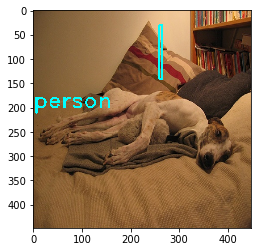

In [32]:
np_img = cv2.imread('./VOCdevkit_train/VOC2007/JPEGImages/000609.jpg')
resized_img = cv2.resize(np_img, (common_params['image_size'], common_params['image_size']))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, common_params['image_size'], common_params['image_size'], 3))

y_pred = solver.make_one_prediction(np_img)
xmin, ymin, xmax, ymax, class_num, conf = process_predicts(y_pred)
class_name = classes_name[class_num]
cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)

plt.imshow(resized_img)

In [ ]:
np.transpose(np.reshape(np.array([np.arange(7)] *7 * 2),(2, 7, 7)), (1, 2, 0))
#np.reshape(np.array([np.arange(7)] *7 * 2),(7, 7, 2))

#np.array([np.arange(7)] *7 * 2)